### Objective: 
Model work time per note with linear regression


### Input Variables:

#### Scribe Experience:
- Note count (number of notes a scribe has written on the day of completion of the note)

#### Note Data:
- E&M Level (Level 1-5)


### Summary:

With the assumption that inexperienced scribes and notes that require more input will take longer to write, scribe experience (measured by cumulative number of notes written at the day of note completion) and note data (E&M level) were included as predictors. 

The note count variable was square-root transformed due to its right skewed distribution. Ordinal encoding was applied to the E&M levels.

The linear model returned a R-squared value of 0.63.

In [84]:
import numpy as np
import pandas as pd
from pandas import DataFrame

import matplotlib.pyplot as plt
import sklearn 
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [85]:
#import appointments table 
appts = pd.read_csv (r'/Users/jihyun.byun/Downloads/bq-results-20210817-141033-zdui0h9d1jli.csv')
df = pd.DataFrame(appts)

#print(appts.head())

In [86]:
#removing rows with "Robin" and "Test" specialties
df = df[(df.group_name != 'Robin') & (df.group_name != 'Test') & (df.group_name != 'the pepper group')]

In [87]:
#create integer for E&M Level, ordinal encoding
def fx(row):
    if row['em_level'] == 'Level 1': val = 1
    elif row['em_level'] == 'Level 2': val = 2
    elif row['em_level'] == 'Level 3': val = 3
    elif row['em_level'] == 'Level 4': val = 4
    elif row['em_level'] == 'Level 5': val = 5
    else : val = 0

    return val

#create new column using the function above
df['em_level_int'] = df.apply(fx, axis=1)

In [88]:
#create integer for Patient Stage, ordinal encoding
def fx(row):
    if row['pt_stage'] == 'Pre-Op': val = 1
    elif row['pt_stage'] == 'Post-Op': val = 2
    elif row['pt_stage'] == 'Telehealth': val = 3
    elif row['pt_stage'] == 'Established': val = 4
    elif row['pt_stage'] == 'New': val = 5
    else : val = 0

    return val

#create new column using the function above
df['pt_stage_int'] = df.apply(fx, axis=1)

In [89]:
#drop unneeded columns
df_ltd = df.drop(['appointment_id', 'doctor_id', 'patient_stage', 'initial_completion_date', 
                  'extractor_id', 'extractor_name', 'first_note_date', 'doctor_name', 
                  'em_code', 'group_id', 'specialty_id',
                  'sub_specialty_name', 'sub_specialty_id', 
                  'procedures_string'], axis=1)

#df_ltd.head()

In [90]:
#reorder columns
#cols = list(df_ltd.columns.values)
#cols

df_ltd = df_ltd[['daily_note_count',
                 'group_name', 'specialty_name',
                 'pt_stage_int', 'pt_stage', 'em_level_int', 'em_level',
                 'worktime']]
#df_ltd

In [91]:
#check for null specialty values
null_specialty = df[df['specialty_name'].isna()]
#null_specialty

In [92]:
#check for null note ct values
null_note_ct = df[df['daily_note_count'].isna()]
#null_note_ct

In [93]:
#check for null worktime values
null_worktime = df[df['worktime'].isna()]
#null_worktime

In [94]:
#check for notes with zero worktime 
zero_worktime = df[df['worktime'] == 0]
#zero_worktime

In [95]:
#check for notes with worktime > 5 hours
worktime_5hr = df[df['worktime'] >= 300]
#worktime_5hr

In [96]:
#df.info()

In [97]:
#remove rows with null values for days of experience, scribe note count, 
# or worktime equal to 0 or greater than 4 hours


df_ltd['group_name'] = df_ltd['group_name'].astype('string')

df_clean = df_ltd[( (df_ltd['group_name']  != 'University of California San Francisco') &
                    df_ltd['daily_note_count'].notna() & 
                   df_ltd['worktime'].notna() &
                   (df_ltd['worktime'] != 0) &
                   (df_ltd['worktime'] < 240 
                   
                   ))]

#df_clean

In [98]:
#replace null (NaN) values with "N/A"
df_clean = df_clean.replace(np.nan, 'N/A', regex=True)
#df_clean.head()

In [99]:
#declare daily note count and worktime as integers
df_clean['daily_note_count'] = df_clean['daily_note_count'].astype('int64')
df_clean['worktime'] = df_clean['worktime'].astype('int64')

Text(0.5, 1.0, 'Histogram of Work Time per Note')

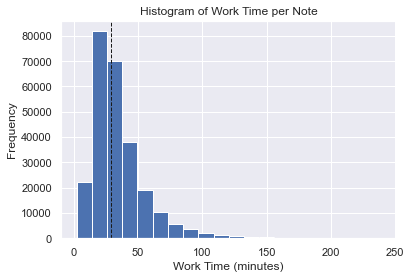

In [100]:
plt.hist(df_clean['worktime'], bins = 20)
plt.axvline(df_clean['worktime'].median(), color='k', linestyle='dashed', linewidth=1)

#plt.hist(df_clean['worktime'], bins = [0,20,40,60,80,100,300])
#plt.hist(df_clean['worktime'], bins = [0,2,4,6,8,10])

sns.set(rc={'figure.figsize':(6,4)})


plt.xlabel("Work Time (minutes)")
plt.ylabel("Frequency")
plt.title("Histogram of Work Time per Note")



### Checking linear regression assumptions: normal distribution of input variables and linear relationship between input / output vars

#### Daily Note Count

1.5811560542099687


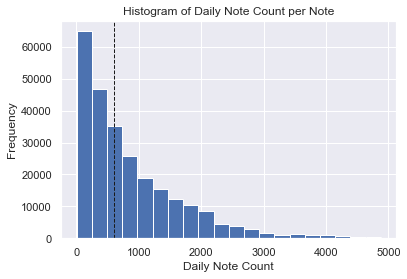

In [20]:
plt.hist(df_clean['daily_note_count'], bins = 20)
plt.axvline(df_clean['daily_note_count'].median(), color='k', linestyle='dashed', linewidth=1)

plt.xlabel("Daily Note Count")
plt.ylabel("Frequency")
plt.title("Histogram of Daily Note Count per Note")

print(df_clean['daily_note_count'].skew())

Text(0.5, 1.0, 'Scatterplot of sqrt(Daily Note Count) vs. Work Time')

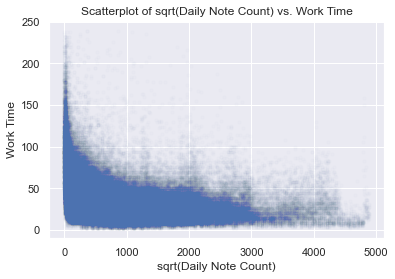

In [21]:
plt.scatter((df_clean['daily_note_count']), df_clean['worktime'], s = 10, alpha = 0.01);
plt.xlabel("sqrt(Daily Note Count)")
plt.ylabel("Work Time")
plt.title("Scatterplot of sqrt(Daily Note Count) vs. Work Time")

Text(0.5, 1.0, 'Median Work Time Over Note Count')

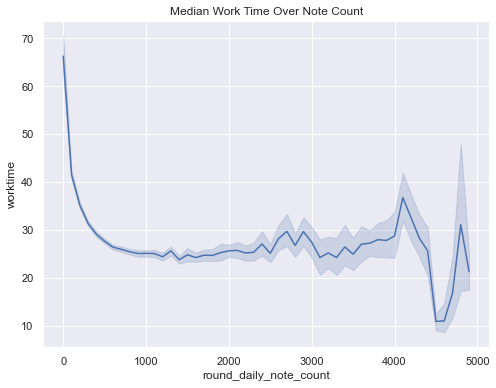

In [74]:
median_note_count = df_clean.groupby('daily_note_count', as_index=False)['worktime'].median()

import math
median_note_count['round_daily_note_count'] = round(median_note_count['daily_note_count'], -2)

sns.lineplot(data=median_note_count, x='round_daily_note_count', y='worktime').set_title('Median Work Time Over Note Count')


0.5014255432584342


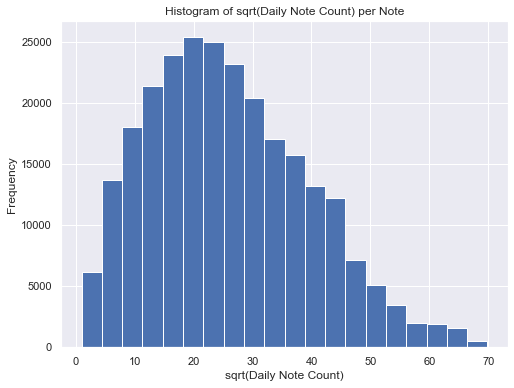

In [75]:
df_clean['daily_note_count_sqrt'] = np.sqrt(df_clean['daily_note_count'])

plt.hist(df_clean['daily_note_count_sqrt'], bins = 20)
plt.xlabel("sqrt(Daily Note Count)")
plt.ylabel("Frequency")
plt.title("Histogram of sqrt(Daily Note Count) per Note")
print(np.sqrt(df_clean['daily_note_count']).skew())

Applying a square root transformation reduces skew from ~1.58 (highly skewed) to ~0.5 (low skew)

[Text(0.5, 0, ''),
 Text(0, 0.5, 'Median Worktime'),
 Text(0.5, 1.0, 'Median Worktime/Note per Specialty with 1 St.Dev Error Bars')]

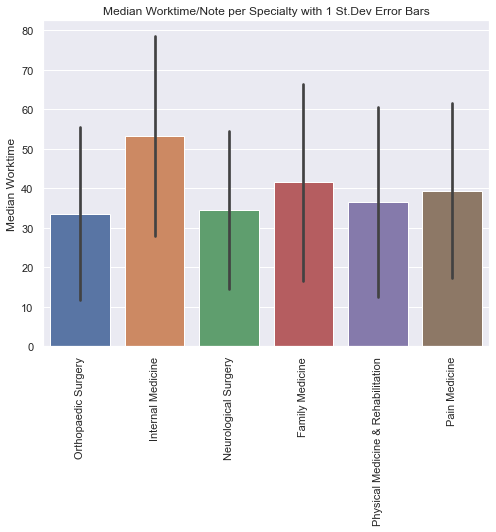

In [76]:
df_clean.groupby('specialty_name', as_index=False)['worktime'].median()

sns.set(rc={'figure.figsize':(8,6)})
plt.xticks(rotation=90)
specialty_plot = sns.barplot('specialty_name', 'worktime', data=df_clean, ci="sd")
specialty_plot.set(xlabel = None, ylabel = "Median Worktime", 
                   title = 'Median Worktime/Note per Specialty with 1 St.Dev Error Bars')

[Text(0.5, 0, ''),
 Text(0, 0.5, 'Median Worktime'),
 Text(0.5, 1.0, 'Median Worktime/Note per Patient Type with 1 St.Dev Error Bars')]

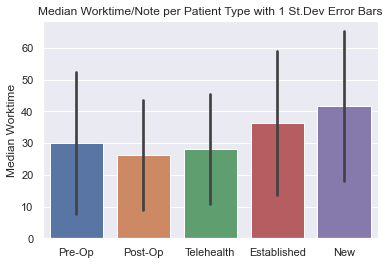

In [77]:
df_clean.groupby('pt_stage', as_index=False)['worktime'].median()

sns.set(rc={'figure.figsize':(6,4)})
specialty_plot = sns.barplot('pt_stage', 'worktime', data=df_clean, ci="sd", order=['Pre-Op', 'Post-Op', 'Telehealth', 'Established', 'New'])
specialty_plot.set(xlabel = None, ylabel = "Median Worktime", title = 'Median Worktime/Note per Patient Type with 1 St.Dev Error Bars')

[Text(0.5, 0, ''),
 Text(0, 0.5, 'Median Worktime'),
 Text(0.5, 1.0, 'Median Worktime/Note with 1 St. Dev Error Bars')]

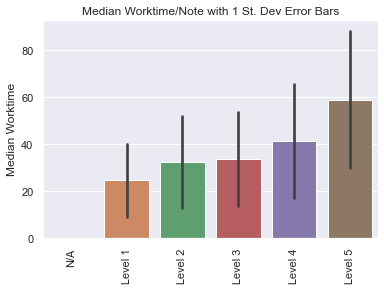

In [78]:
df_clean.groupby('em_level', as_index=False)['worktime'].median()

sns.set(rc={'figure.figsize':(6,4)})
plt.xticks(rotation=90)
specialty_plot = sns.barplot('em_level', 'worktime', data=df_clean, ci="sd", order=['N/A', 'Level 1', 'Level 2', 'Level 3', 'Level 4', 'Level 5'])
specialty_plot.set(xlabel = None, ylabel = "Median Worktime", title = 'Median Worktime/Note with 1 St. Dev Error Bars')

In [79]:
df_clean_1 = df_clean[['daily_note_count_sqrt',
                      #'pt_stage', 
                       'em_level_int', 
                      'worktime']]

In [80]:
#create input and output arrays
x, y = df_clean_1.iloc[:, :-1], df_clean_1.iloc[:,-1]
#x, y

In [81]:
#One-hot encode
#pd.get_dummies(x)

### Linear Model:

#### Linear model with sqrt(note count) and encoded patient stage to predict work time, R-squared = 0.63

In [83]:
import statsmodels.regression.linear_model as sm

ols = sm.OLS(endog = y, exog = x).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               worktime   R-squared (uncentered):                   0.630
Model:                            OLS   Adj. R-squared (uncentered):              0.630
Method:                 Least Squares   F-statistic:                          2.183e+05
Date:                Fri, 03 Sep 2021   Prob (F-statistic):                        0.00
Time:                        08:34:33   Log-Likelihood:                     -1.1916e+06
No. Observations:              256656   AIC:                                  2.383e+06
Df Residuals:                  256654   BIC:                                  2.383e+06
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
daily_note_count_sqrt     0.1828      0.003     71.607      0.000       0.178       0.188
em_level_int              9.4618      0.025    382.794      0.000       9.413       9.510
==============================================================================
Omnibus:                    88812.529   Durbin-Watson:                   1.850
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           435675.939
Skew:                           1.614   Prob(JB):                         0.00
Kurtosis:                       8.506   Cond. No.                         14.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""